## Current 'clean' Modeling Notebook

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn import svm
import hdbscan
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('../../../../datasets/Project4/workingfiles/train.csv')

In [42]:
# train = pd.read_csv('~/Dropbox/DSI/train.csv')

In [3]:
cols = [i for i in train.columns]

In [4]:
# deal with NaNs
for i in train.columns[train.isnull().sum()>0]: # for all the columns with nans
    mean_avg_temp = train.loc[train[i].isnull()==True,'Tavg'].mean() # what is the mean Tavg
    mean_i_val = train.loc[train.Tavg==mean_avg_temp,i].mean() # what is i val for that Tavg
    train.loc[train[i].isnull()==True,'to_fill'] = mean_i_val
    train[i] = train[i].fillna(train.to_fill)
    train.drop('to_fill',axis=1,inplace=True)

In [5]:
dates = ['_date-'+str(i) for i in range(1,7)]
for i,v in enumerate(cols):
    try:
        if v in dates: # drops out the repeated date column
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    try:
        if 'Date_date-' in v:
            train.drop(v,axis=1,inplace=True)
    except:
        pass

In [6]:
le = LabelEncoder()
le.fit(train.Species)
train['mosquito'] = le.transform(train.Species)
le.fit(train.Trap)
train['trap_e'] = le.transform(train.Trap)

In [8]:
# train.head()

In [13]:
weather_cats = train.columns[300:333].tolist()

In [15]:
new_cats = []
for c in range(1,7):
    for w in weather_cats:
        c_string = str(c)
        cat = str(w)+'_date-'+c_string
        new_cats.append(cat)

In [16]:
weather_cats = weather_cats + new_cats

In [17]:
scale_exclude = ['Date', 'mosquito', 'Species', 'Trap', 'trap_e','Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 'Weather_Station',
                'Trap_Mosquitos_today','Trap_Species_today','min_Wnv_species_today','Epoch',
                'Latitude','Longitude']

In [18]:
for c in weather_cats:
    scale_exclude.append(c)

In [19]:
scale_cols = [x for x in train.columns if x not in scale_exclude]

In [20]:
train.dropna(inplace=True)

In [21]:
# Scaling all non-categorical numerical values using standard scaler

std_scale = StandardScaler()
train[scale_cols] = std_scale.fit_transform(train[scale_cols])

In [22]:
model_exclude_cols = ['Date', 'Species', 'Trap', 'trap-e', 'Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 'NumMosquitos' 'Weather_Station']

In [23]:
X_cols_full = [i for i in train.columns if i not in model_exclude_cols]

In [24]:
# Defining X (2 versions, one of which will be PCA'd), and y
X = train[X_cols_full]
y = train.WnvPresent

In [25]:
X.head()

,Latitude,Longitude,NumMosquitos,Weather_Station,T152_dist,T153_dist,T019_dist,T018_dist,T156_dist,T157_dist,...,SG_date-6,PO_date-6,PL_date-6,SN_date-6,Trap_Mosquitos_today,Trap_Species_today,min_Wnv_species_today,Epoch,mosquito,trap_e
0,41.954690,-87.800991,-0.730363,1,0.053344,-1.068747,-0.859025,-0.849954,0.781999,0.691519,...,0,0,0,0,2,1,0,1180396800,2,1
1,41.954690,-87.800991,-0.730363,1,0.053344,-1.068747,-0.859025,-0.849954,0.781999,0.691519,...,0,0,0,0,2,1,0,1180396800,3,1
2,41.994991,-87.769279,-0.730363,1,0.579959,-0.651069,-0.940832,-1.234347,1.355409,1.089867,...,0,0,0,0,1,1,0,1180396800,3,6
3,41.974089,-87.824812,-0.730363,1,0.530294,-0.727930,-0.619368,-0.754953,1.158362,1.151985,...,0,0,0,0,5,1,0,1180396800,2,14
4,41.974089,-87.824812,-0.543421,1,0.530294,-0.727930,-0.619368,-0.754953,1.158362,1.151985,...,0,0,0,0,5,4,0,1180396800,3,14


In [26]:
# TTS for non-PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)

In [27]:
# PCA-ifying 
pca = PCA(n_components=31,svd_solver='full') # 30 components describe 85% of variance
pca.fit(X)
X_pca = pca.transform(X)
# print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()


1.0


In [28]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y,stratify=y, test_size=0.33)

### Model Eval Formulas

In [42]:
def evaluate_model(m, X=X, y=y, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model = m.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score:\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X, y,cv=7, n_jobs=-1)
    print "Cross Val Scores:", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals:"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix:"
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report:"
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return model

## Models

### KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.942 


Cross Val Scores: [ 0.94852437  0.07824296  0.43917526  0.94845361  0.1532646   0.44742268
  0.11408935] 

Cross Val mean ± Std. Dev:0.447 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           31          143
Actual 0           52         3137 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.37      0.18      0.24       174

avg / total       0.93      0.94      0.93      3363



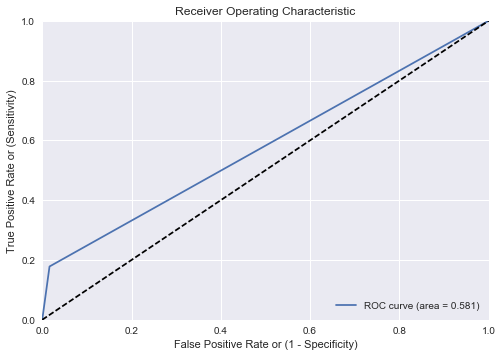

In [43]:
# All data
KNN = KNeighborsClassifier(n_neighbors=3)
KNN_model = evaluate_model(KNN)

In [44]:
KNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [45]:
KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.944 


Cross Val Scores: [ 0.94921071  0.07824296  0.43917526  0.94845361  0.1532646   0.44742268
  0.11546392] 

Cross Val mean ± Std. Dev:0.447 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           28          146
Actual 0           44         3145 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      3189
          1       0.39      0.16      0.23       174

avg / total       0.93      0.94      0.93      3363



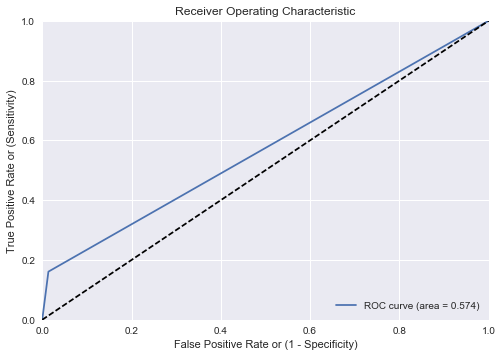

In [31]:
KNN_pca = KNeighborsClassifier(n_neighbors=3)
evaluate_model(KNN_pca, X_pca, y, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

### AdaBoost

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.939 


Cross Val Scores: [ 0.94783802  0.65957447  0.91408935  0.94845361  0.89621993  0.89621993
  0.74776632] 

Cross Val mean ± Std. Dev:0.859 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           41          133
Actual 0           71         3118 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.3

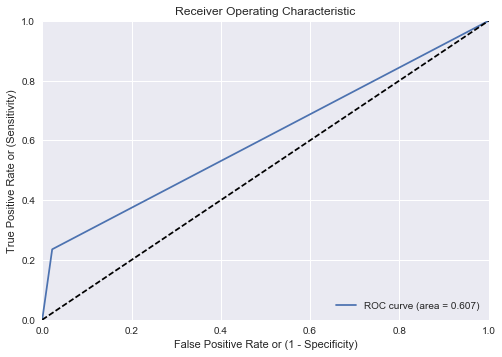

In [32]:
rf = RandomForestClassifier(max_features = 10)
ada = AdaBoostClassifier(base_estimator=rf)
evaluate_model(ada)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.934 


Cross Val Scores: [ 0.94783802  0.45367193  0.89072165  0.94845361  0.89140893  0.88728522
  0.41237113] 

Cross Val mean ± Std. Dev:0.776 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           33          141
Actual 0           82         3107 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      3189
          1       0.2

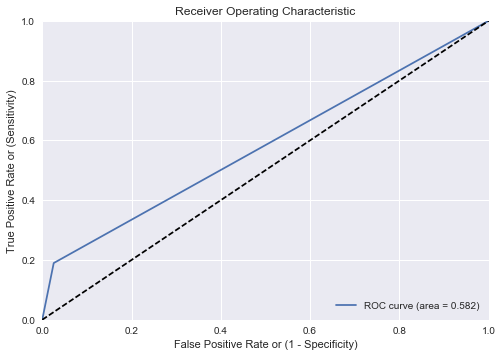

In [33]:
# PCA
ada_pca = AdaBoostClassifier(base_estimator=rf)
evaluate_model(ada_pca, X_pca, y, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

### Random Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.952 


Cross Val Scores: [ 0.95126973  0.51475635  0.93058419  0.9532646   0.89347079  0.92852234
  0.57388316] 

Cross Val mean ± Std. Dev:0.821 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           40          134
Actual 0           29         3160 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      3189
          1       0.58      0.23      0.33       174

avg / total       0.94      0.95      0.94      3363



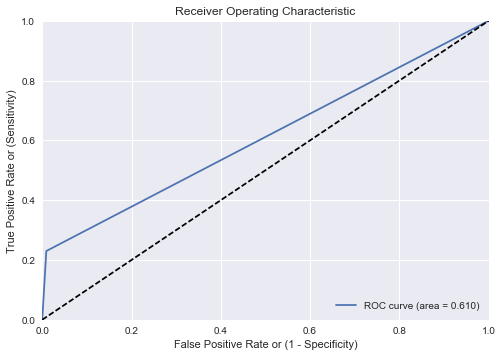

In [34]:
#Non PCA
RF_solo = RandomForestClassifier()
evaluate_model(RF_solo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.94 


Cross Val Scores: [ 0.94783802  0.25737817  0.79862543  0.94845361  0.87353952  0.62886598
  0.11546392] 

Cross Val mean ± Std. Dev:0.653 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           17          157
Actual 0           45         3144 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.27      0.10      0.14       174

avg / total       0.92      0.94      0.93      3363



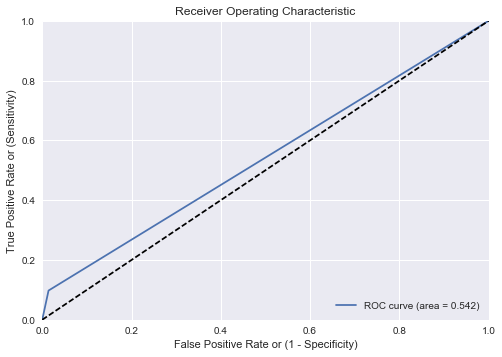

In [35]:
# PCA version
RF_solo_PCA = RandomForestClassifier()
evaluate_model(RF_solo_PCA, X_pca, y, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

### SVMs

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Accuracy Score:	0.945 


Cross Val Scores: [ 0.94783802  0.6273164   0.89965636  0.94845361  0.91340206  0.91408935
  0.77800687] 

Cross Val mean ± Std. Dev:0.861 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           29          145
Actual 0           41         3148 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      3189
          1       0.41      0.17      0.24       174

avg / total       0.93      0.94      0.93      3363



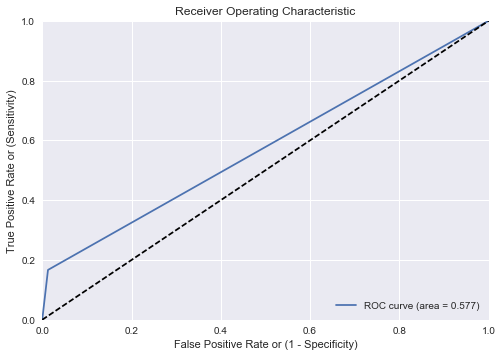

In [36]:
# Non PCA
SVM = svm.SVC(C=10, kernel='rbf', probability=True)
evaluate_model(SVM)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Accuracy Score:	0.939 


Cross Val Scores: [ 0.94783802  0.77625257  0.9257732   0.94845361  0.92164948  0.93402062
  0.88247423] 

Cross Val mean ± Std. Dev:0.905 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           15          159
Actual 0           45         3144 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.25      0.09      0.13       174

avg / total       0.92      0.94      0.93      3363



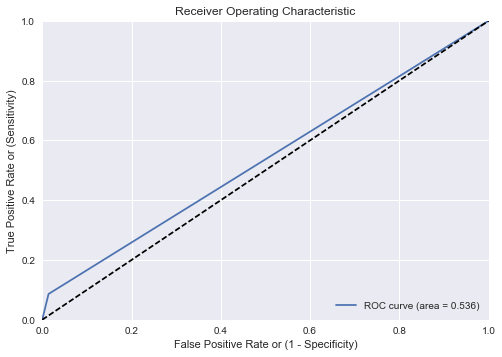

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
#  PCA
SVM_pca = svm.SVC(C=10, kernel='rbf', probability=True)
evaluate_model(SVM_pca, X_pca, y, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

### Logistic Regression

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.959 


Cross Val Scores: [ 0.86822237  0.53466026  0.89140893  0.93058419  0.86391753  0.7814433
  0.59793814] 

Cross Val mean ± Std. Dev:0.781 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           67          107
Actual 0           31         3158 

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3189
          1       0.68      0.39      0.49       174

avg / total       0.95      0.96      0.95      3363



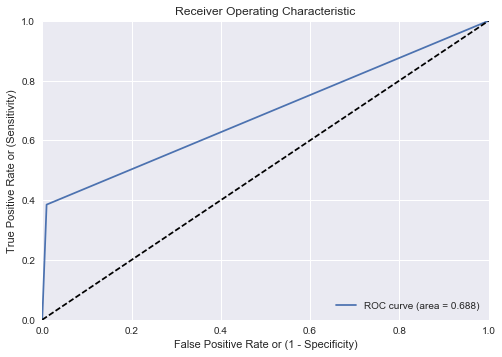

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
# Non PCA
logreg = LogisticRegression(C=2, penalty='l1')
evaluate_model(logreg)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.946 


Cross Val Scores: [ 0.94783802  0.87508579  0.94845361  0.94914089  0.88453608  0.94845361
  0.81030928] 

Cross Val mean ± Std. Dev:0.909 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            3          171
Actual 0           11         3178 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.21      0.02      0.03       174

avg / total       0.91      0.95      0.92      3363



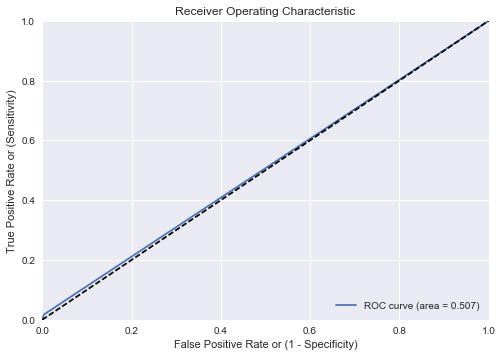

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
#  PCA
logreg_pca = LogisticRegression(C=2, penalty='l1')
evaluate_model(logreg_pca, X_pca, y, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

## XGBoost

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.98 


Cross Val Scores: [ 0.96842828  0.77282086  0.97319588  0.97457045  0.95395189  0.97319588
  0.92989691] 

Cross Val mean ± Std. Dev:0.935 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1          132           42
Actual 0           24         3165 

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3189
          1       0.85      0.76      0.80       174

avg / total       0.98      0.98      0.98      3363



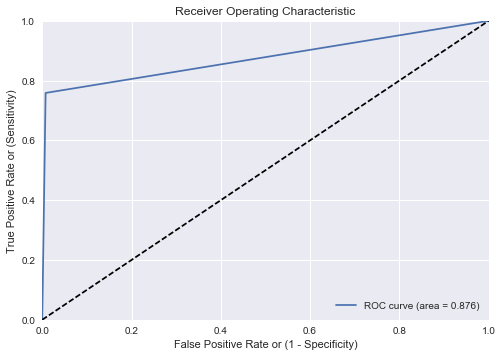

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [49]:
# Non PCA
XGB = XGBClassifier()
evaluate_model(XGB)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94783802  0.11805079  0.94707904  0.94845361  0.88797251  0.87766323
  0.11546392] 

Cross Val mean ± Std. Dev:0.692 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            5          169
Actual 0            3         3186 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.62      0.03      0.05       174

avg / total       0.93      0.95      0.93      3363



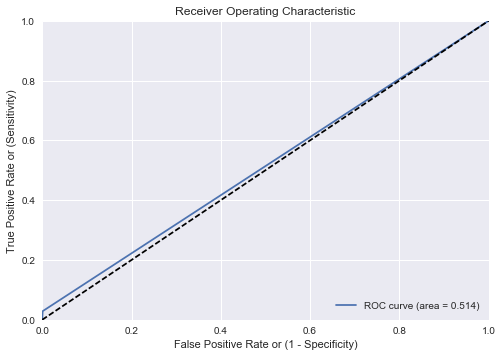

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [50]:
#  PCA
XGB_pca = XGBClassifier()
evaluate_model(XGB_pca, X_pca, y, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

### Gradient Boost

### HDBSCAN

In [51]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)

In [52]:
# Non_PCA
clusterer.fit(X)
cluster_labels = clusterer.labels_
print(clusterer.labels_.max())

83


In [53]:
# PCA
clusterer.fit(X_pca)
cluster_labels_PCA = clusterer.labels_
print(clusterer.labels_.max())

83


In [54]:
X_clusters = X.copy()
X_clusters_pca = X_pca.copy()

In [55]:
X_clusters['HDBSCAN-full'] = cluster_labels
np.append(X_clusters_pca,cluster_labels_PCA)

array([ -8.58709579e+07,  -3.30700810e+02,  -1.84478463e+01, ...,
         1.80000000e+01,   1.80000000e+01,   1.80000000e+01])

In [63]:
# X_clusters.head().T

In [56]:
X_clusters.drop('NumMosquitos', axis=1, inplace=True)

In [57]:
## TTS for non-PCA clustered
X_clust_train, X_clust_test, y_clust_train, y_clust_test = train_test_split(X_clusters, y, test_size=.33, stratify=y)

In [58]:
## TTS for PCA clustered
X_ClPca_train, X_ClPca_test, y_ClPca_train, y_ClPca_test = train_test_split(X_clusters_pca, y, test_size = .33, stratify=y)

##### Running Models with Cluster Feature Added

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.974 


Cross Val Scores: [ 0.96705559  0.77076184  0.97182131  0.97113402  0.95189003  0.96907216
  0.92989691] 

Cross Val mean ± Std. Dev:0.933 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1          119           55
Actual 0           34         3155 

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3189
          1       0.78      0.68      0.73       174

avg / total       0.97      0.97      0.97      3363



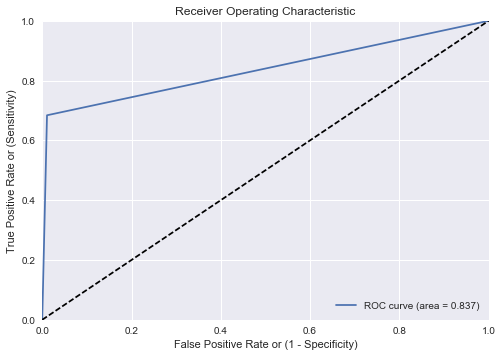

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [60]:
## XG boost with clusters, non PCA
XGB_cluster = XGBClassifier()
evaluate_model(XGB_cluster, X_clusters, y, X_clust_train, X_clust_test, y_clust_train, y_clust_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.947 


Cross Val Scores: [ 0.94783802  0.11805079  0.94707904  0.94845361  0.88797251  0.87766323
  0.11546392] 

Cross Val mean ± Std. Dev:0.692 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            3          171
Actual 0            6         3183 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.33      0.02      0.03       174

avg / total       0.92      0.95      0.92      3363



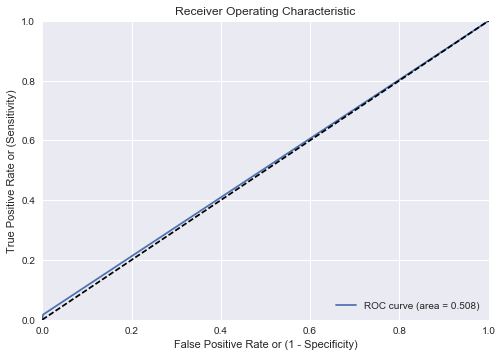

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [61]:
## XG boost with clusters, PCA
XGB_cluster_pca = XGBClassifier()
evaluate_model(XGB_cluster_pca, X_clusters_pca, y, X_ClPca_train, X_ClPca_test, y_ClPca_train, y_ClPca_test)

##### Gradient boost with HDBSCAN outputs

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False) 

Accuracy Score:	0.974 


Cross Val Scores: [ 0.97185999  0.77076184  0.96013746  0.97388316  0.95257732  0.96975945
  0.92989691] 

Cross Val mean ± Std. Dev:0.933 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1          117           57
Actual 0           32         3157 

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3189
          1       0.79      0.67      0.72       174

avg / total       0.97      0.97      0.97    

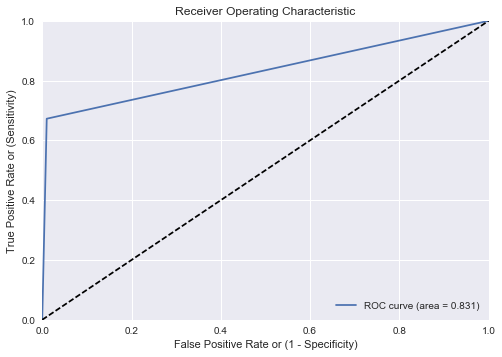

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [65]:
GB_cluster = GradientBoostingClassifier()
evaluate_model(GB_cluster, X_clusters, y, X_clust_train, X_clust_test, y_clust_train, y_clust_test)